In [29]:
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import cv2

In [67]:
train_df = pd.read_excel(r'train/train.xlsx')
# train_df = train_df.reset_index(inplace=True)
# измение строк с путями
train_df['image_path'] = train_df['image_path'].str.replace('\\', '/')
train_df['annotation_path_label'] = train_df['annotation_path_label'].str.replace('\\', '/')
train_df = train_df[train_df['pathology'] == 1]
print(f'Количество исследований: {len(train_df)}')
train_df[:10]

Количество исследований: 262


,Unnamed: 0,ID,image_path,annotation_path_label,pathology
0,0,image_393.jpg,train/images/image_393.jpg,train/annotation/annotation_393.json,1
1,1,image_326.jpg,train/images/image_326.jpg,train/annotation/annotation_326.json,1
2,2,image_290.jpg,train/images/image_290.jpg,train/annotation/annotation_290.json,1
3,3,image_206.jpg,train/images/image_206.jpg,train/annotation/annotation_206.json,1
5,5,image_252.jpg,train/images/image_252.jpg,train/annotation/annotation_252.json,1
8,8,image_316.jpg,train/images/image_316.jpg,train/annotation/annotation_316.json,1
9,9,image_469.jpg,train/images/image_469.jpg,train/annotation/annotation_469.json,1
10,10,image_112.jpg,train/images/image_112.jpg,train/annotation/annotation_112.json,1
12,12,image_187.jpg,train/images/image_187.jpg,train/annotation/annotation_187.json,1
13,13,image_237.jpg,train/images/image_237.jpg,train/annotation/annotation_237.json,1


In [68]:
idx = 0

annotation_path = train_df['annotation_path_label'][idx]
img_path = train_df['image_path'][idx]

with open(annotation_path, 'r') as f:
    bbox_data = json.load(f)
    x, y, w, h = bbox_data['annotations'][0]['bbox']

img = Image.open(img_path)

# img.crop()
print(x, y, w, h)

358.32 1180.39 107.19 69.9699999999998


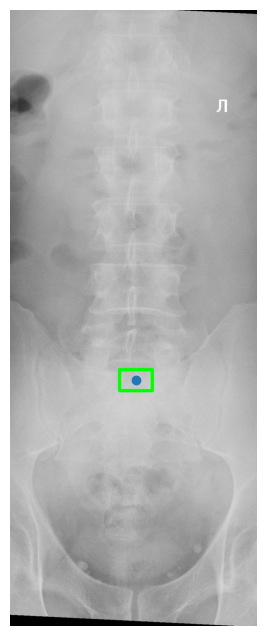

In [69]:
# Загрузка изображения и JSON
image_path = train_df['image_path'][0]
json_path = train_df['annotation_path_label'][0]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация в RGB для корректного отображения
with open(json_path, 'r') as f:
    data = json.load(f)

# Извлечение координат bbox
bbox = data['annotations'][0]['bbox']
x, y, w, h = map(int, bbox)
x_center = x + (w/2)
y_center = y + (h/2)

# Рисование прямоугольника
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)

# Отображение с помощью matplotlib
plt.figure(figsize=(12, 8))
plt.scatter(x_center, y_center)
plt.imshow(image)
plt.axis('off')
plt.show()

In [70]:
h_image = image.shape[0]
w_image = image.shape[1]

In [71]:
def create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image):
    x_centerY = x_center / w_image
    y_centerY = y_center / h_image
    wY = w / w_image
    hY = h / h_image
    return f'0 {x_centerY} {y_centerY} {wY} {hY}'

In [72]:
create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image)

'0 0.5092821782178217 0.6006429277942631 0.13242574257425743 0.03412462908011869'

In [76]:
import shutil

id_list = train_df['Unnamed: 0'].to_list()

# for idx in range(len(train_df)):
for idx in id_list:
    image_path = train_df['image_path'][idx]
    json_path = train_df['annotation_path_label'][idx]
    image = cv2.imread(image_path)
    with open(json_path, 'r') as f:
        data = json.load(f)
    x, y, w, h = map(int, bbox)
    x_center = x + (w/2)
    y_center = y + (h/2)
    h_image = image.shape[0]
    w_image = image.shape[1]
    
    with open(f'yolo_dataset/labels/{idx}.txt', 'w') as f:
        f.write(create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image))


    shutil.copy(train_df['image_path'][idx], os.path.join(f'yolo_dataset/images/{idx}.jpg'))
    

In [77]:
import os
import shutil
import random

# Определяем пути к исходным и целевым директориям
source_dir = 'yolo_dataset'
train_dir = 'yolo_dataset/train'
val_dir = 'yolo_dataset/val'
test_dir = 'yolo_dataset/test'

# Создаем целевые директории, если они не существуют
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dir, 'labels'), exist_ok=True)

# Получаем список всех файлов изображений
image_files = [f for f in os.listdir(os.path.join(source_dir, 'images')) if f.endswith('.jpg')]

# Перемешиваем список файлов
random.shuffle(image_files)

# Определяем размеры наборов данных
total_files = len(image_files)
train_size = int(0.7 * total_files)
val_size = int(0.15 * total_files)
test_size = total_files - train_size - val_size

# Разделяем файлы на наборы
train_files = image_files[:train_size]
val_files = image_files[train_size:train_size+val_size]
test_files = image_files[train_size+val_size:]

# Функция для копирования файлов
def copy_files(file_list, target_dir):
    for file in file_list:
        image_src = os.path.join(source_dir, 'images', file)
        label_src = os.path.join(source_dir, 'labels', os.path.splitext(file)[0] + '.txt')
        
        image_dst = os.path.join(target_dir, 'images', file)
        label_dst = os.path.join(target_dir, 'labels', os.path.splitext(file)[0] + '.txt')
        
        shutil.copy(image_src, image_dst)
        shutil.copy(label_src, label_dst)

# Копируем файлы в соответствующие директории
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print(f"Разделение завершено. Тренировочных файлов: {len(train_files)}, Валидационных: {len(val_files)}, Тестовых: {len(test_files)}")

Разделение завершено. Тренировочных файлов: 183, Валидационных: 39, Тестовых: 40


In [44]:
train_df.head()

,ID,image_path,annotation_path_label,pathology
0,image_393.jpg,train/images/image_393.jpg,train/annotation/annotation_393.json,1
1,image_326.jpg,train/images/image_326.jpg,train/annotation/annotation_326.json,1
2,image_290.jpg,train/images/image_290.jpg,train/annotation/annotation_290.json,1
3,image_206.jpg,train/images/image_206.jpg,train/annotation/annotation_206.json,1
5,image_252.jpg,train/images/image_252.jpg,train/annotation/annotation_252.json,1


In [ ]:
def create_yolo_dataset(df, dataset_path):
    

In [ ]:
x_center = x + (w/2)
y_center = y + (h/2)


In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
def convert_bbox(size, box):
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0] + box[2]/2.0) * dw
    y = (box[1] + box[3]/2.0) * dh
    w = box[2] * dw
    h = box[3] * dh
    return (x,y,w,h)

def convert_annotation(row):
    image_path = row['image_path']
    json_path = row['annotation_path_label']
    
    with open(json_path, 'r') as f:
        data = json.load(f)

    img = Image.open(image_path)
    w, h = img.size

    output_path = os.path.splitext(image_path)[0] + '.txt'
    
    with open(output_path, 'w') as out_file:
        for ann in data['annotations']:
            bbox = ann.get('bbox')
            if bbox:
                bb = convert_bbox((w,h), bbox)
                out_file.write(f"0 {bb[0]} {bb[1]} {bb[2]} {bb[3]}\n")
    
    return output_path

# Предполагается, что у вас есть DataFrame df
train_df['yolo_annotation'] = train_df.apply(convert_annotation(train_df), axis=1)

TypeError: unhashable type: 'Series'

In [ ]:
image = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))